# Assessment 3: RNNs for stock price prediction

In [2]:
import sys, site
from pathlib import Path

################################# NOTE #################################
#  Please be aware that if colab installs the latest numpy and pyqlib  #
#  in this cell, users should RESTART the runtime in order to run the  #
#  following cells successfully.                                       #
########################################################################

try:
    import qlib
except ImportError:
    # install qlib
    ! pip install --upgrade numpy
    ! pip install pyqlib
    if "google.colab" in sys.modules:
        # The Google colab environment is a little outdated. We have to downgrade the pyyaml to make it compatible with other packages
        ! pip install pyyaml==5.4.1
    # reload
    site.main()

scripts_dir = Path.cwd().parent.joinpath("scripts")
if not scripts_dir.joinpath("get_data.py").exists():
    # download get_data.py script
    scripts_dir = Path("~/tmp/qlib_code/scripts").expanduser().resolve()
    scripts_dir.mkdir(parents=True, exist_ok=True)
    import requests

    with requests.get("https://raw.githubusercontent.com/microsoft/qlib/main/scripts/get_data.py", timeout=10) as resp:
        with open(scripts_dir.joinpath("get_data.py"), "wb") as fp:
            fp.write(resp.content)

In [3]:
## Dataset
import qlib
from qlib.constant import REG_US
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
## Data manioulation
import pandas as pd
import numpy as np
import datetime as dt
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## pytorch part
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [4]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Set the seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


Using device: cpu



## Step01: Data exploration

In [5]:
# use default data
# NOTE: need to download data from remote: python scripts/get_data.py qlib_data_cn --target_dir ~/.qlib/qlib_data/cn_data
# from qlib.config import REG_US
provider_uri = "~/.qlib/qlib_data/us_data"  # target_dir
if not exists_qlib_data(provider_uri):
    print(f"Qlib data is not found in {provider_uri}")
    sys.path.append(str(scripts_dir))
    from get_data import GetData

    GetData().qlib_data(target_dir=provider_uri, region=REG_US)
qlib.init(provider_uri=provider_uri, region=REG_US)

[12872:MainThread](2023-11-20 00:14:18,210) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[12872:MainThread](2023-11-20 00:14:18,217) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[12872:MainThread](2023-11-20 00:14:18,218) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/possa/.qlib/qlib_data/us_data')}


In [6]:
from qlib.data import D
# parameter selection
# index_list  = ['^GSPC','^IXIC','^DJI']
# index_list  = ['AAPL', 'MSFT']
# index_name  = ['Apple', 'Microsoft']
# index_list  = ['AAPL']
# index_name  = ['Apple']
# fields = ['$close', '$volume', '$open', '$high', '$low']

# df = D.features(D.instruments("all"), ["$close"], freq="day")
# inst = D.list_instruments(D.instruments(symbols ), freq="day", as_list=True) # show the selecting symbols 

# Fetch daily data for the indices
def set_df():
    # select the index & Fleids
    index_list  = ['^GSPC']
    # index_list  = ['AAPL', 'MSFT']
    # fields = ['$close', '$volume', '$open', '$high', '$low']
    fields = ['$close']
    # download dataset
    df = D.features(index_list , fields, freq='day')
    
    # manipulated the dataset
    df = df.reset_index()
    # df.columns = ['symbols','date','close','volume','open','high','low']
    df.columns = ['symbols','date','close']
    df = df.drop(columns='symbols')
    df.date = df.date.dt.date
    print(f"Period since {min(df.date)} to {max(df.date)}: {max(df.date) - min(df.date)}")
    df = df.set_index(['date'])
    df.index = pd.to_datetime(df.index)
    if not df.index.is_monotonic:
        df = df.sort_index()
    df = df.rename(columns={'close': 'value'})
    return df, index_list

df_all, index_list = set_df()

Period since 1999-12-31 to 2020-11-10: 7620 days, 0:00:00


In [7]:
df_all.tail(5)

,value
date,
2020-11-04,2.343672
2020-11-05,2.389280
2020-11-06,2.388593
2020-11-09,2.416539
2020-11-10,2.413157


### Exploratory Image analysis

In [8]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [9]:
plot_dataset(df_all, title='data provide the S&P500 index since starting point')

In [10]:
df_all

,value
date,
1999-12-31,1.000000
2000-01-03,0.990451
2000-01-04,0.952472
2000-01-05,0.954303
2000-01-06,0.955215
...,...
2020-11-04,2.343672
2020-11-05,2.389280
2020-11-06,2.388593


In [11]:
df_all.index.year > 2015

array([False, False, False, ...,  True,  True,  True])

In [12]:
print(f"the maxmimum date: {max(df_all.index)} with period of 5 years")
df = df_all[df_all.index.year >= 2015]
print(f"so the period will filter since {min(df.index)} to {max(df.index)}")

the maxmimum date: 2020-11-10 00:00:00 with period of 5 years
so the period will filter since 2015-01-02 00:00:00 to 2020-11-10 00:00:00


In [13]:
# features: lagging
def generate_time_lags(df, period):
    df_n = df.copy()
    # for n in range(1, n_lags + 1):
    for n in period:
        df_n[f"lag{n}"] = df_n["value"].shift(n)
    df_n = df_n.iloc[max(period):]
    return df_n

# features: encode the day features
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def onehot_encode(df, onehot_columns):
    ct = ColumnTransformer(
        [('onehot', OneHotEncoder(drop='first'), onehot_columns)],
        remainder='passthrough'
        )
    return ct.fit_transform(df)


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def onehot_encode_pd(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)
    
    return pd.concat([df, dummies], axis=1).drop(columns=cols)

# features: holidays
from datetime import date
import holidays

us_holidays = holidays.US()

def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in us_holidays) else 0

def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday))

# combine feature
def add_feature(df):
    df = (
                df
                .assign(day = df.index.day)
                .assign(month = df.index.month)
                .assign(day_of_week = df.index.dayofweek)
                .assign(week_of_year=df.index.isocalendar().week)
              )
    # df = generate_time_lags(df, [7,14,30,60,90])
    df = generate_time_lags(df, [1,7,14,30,60,90,180])
    df['res_lag1'] = df['value'] - df['lag1']
    
    df = add_holiday_col(df, us_holidays)
    df = onehot_encode_pd(df, ['month','day','day_of_week','week_of_year'])
    # df = onehot_encode_pd(df, ['month','day','day_of_week'])
    return df

df_feature = add_feature(df)
df_feature
# print(df_feature.head(3))

,value,lag1,lag7,lag14,lag30,lag60,lag90,lag180,res_lag1,is_holiday,...,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
date,,,,,,,,,,,,,,,,,,,,,
2015-09-21,1.338758,1.332673,1.328766,1.342304,1.414034,1.430873,1.428266,1.400851,0.006085,0,...,0,0,0,0,0,0,0,0,0,0
2015-09-22,1.322266,1.338758,1.334729,1.302603,1.432146,1.430315,1.443662,1.375246,-0.016491,0,...,0,0,0,0,0,0,0,0,0,0
2015-09-23,1.319558,1.322266,1.329270,1.326432,1.418458,1.400470,1.444771,1.363015,-0.002709,0,...,0,0,0,0,0,0,0,0,0,0
2015-09-24,1.315120,1.319558,1.346326,1.327977,1.419806,1.404193,1.449175,1.378867,-0.004438,0,...,0,0,0,0,0,0,0,0,0,0
2015-09-25,1.314507,1.315120,1.358047,1.307620,1.417995,1.413932,1.448242,1.403532,-0.000613,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-04,2.343672,2.293115,2.314766,2.370829,2.203110,2.268974,2.078094,2.295886,0.050556,0,...,0,1,0,0,0,0,0,0,0,0
2020-11-05,2.389280,2.343672,2.307762,2.371149,2.209692,2.300732,2.110117,2.271737,0.045609,0,...,0,1,0,0,0,0,0,0,0,0
2020-11-06,2.388593,2.389280,2.226326,2.332428,2.244996,2.296022,2.120715,2.195603,-0.000688,0,...,0,1,0,0,0,0,0,0,0,0


## Step 03: Data splitting

In [14]:
# splitting criteria training 70%, validation 20% and testing 10%

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def split_data(df, target_col):
    train_size = int(len(df) * 0.7)
    valid_size = int(len(df) * 0.2)
    
    # split for train / valid / test
    train_data = df[:train_size]
    valid_data = df[train_size:train_size + valid_size]
    test_data = df[train_size + valid_size:]
    
    print(f"Training size: {len(train_data)} period {train_data.index[0]} to {train_data.index[len(train_data)-1]} \nValidation size: {len(valid_data)} period {valid_data.index[0]} to {valid_data.index[len(valid_data)-1]}\ntest_data size: {len(test_data)} period {test_data.index[0]} to {test_data.index[len(test_data)-1]}")
    
    x_train, y_train = feature_label_split(train_data, target_col)
    x_valid, y_valid = feature_label_split(valid_data, target_col)
    x_test, y_test = feature_label_split(test_data, target_col)
    
    # return train_data,valid_data, test_data
    return x_train, y_train, x_valid, y_valid, x_test, y_test
    
    
# train_size = int(len(df) * 0.7)
# valid_size = int(len(df) * 0.2)

# train_data = df[:train_size]
# valid_data = df[train_size:train_size + valid_size]
# test_data = df[train_size + valid_size:]

# print(f"Training size: {len(train_data)} period {train_data.index[0]} to {train_data.index[len(train_data)-1]} \nValidation size: {len(valid_data)} period {valid_data.index[0]} to {valid_data.index[len(valid_data)-1]}\ntest_data size: {len(test_data)} period {test_data.index[0]} to {test_data.index[len(test_data)-1]}")

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_feature, 'value')

X_train

Training size: 907 period 2015-09-21 00:00:00 to 2019-04-29 00:00:00 
Validation size: 259 period 2019-04-30 00:00:00 to 2020-05-07 00:00:00
test_data size: 130 period 2020-05-08 00:00:00 to 2020-11-10 00:00:00


,lag1,lag7,lag14,lag30,lag60,lag90,lag180,res_lag1,is_holiday,week_of_year_1,...,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
date,,,,,,,,,,,,,,,,,,,,,
2015-09-21,1.332673,1.328766,1.342304,1.414034,1.430873,1.428266,1.400851,0.006085,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-09-22,1.338758,1.334729,1.302603,1.432146,1.430315,1.443662,1.375246,-0.016491,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-09-23,1.322266,1.329270,1.326432,1.418458,1.400470,1.444771,1.363015,-0.002709,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-09-24,1.319558,1.346326,1.327977,1.419806,1.404193,1.449175,1.378867,-0.004438,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-09-25,1.315120,1.358047,1.307620,1.417995,1.413932,1.448242,1.403532,-0.000613,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-23,1.979221,1.965847,1.951499,1.894368,1.813687,1.794644,1.924261,0.017499,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-04-24,1.996719,1.978840,1.955692,1.899963,1.799456,1.804370,1.933197,-0.004376,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-04-25,1.992343,1.977594,1.959769,1.913167,1.796835,1.804009,1.940037,-0.000735,0,0,...,0,0,0,0,0,0,0,0,0,0


## Step 3: Data Preprocessing

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()
 
X_train, y_train, X_val, y_val, X_test, y_test    
    
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [16]:
def create_dataset(dataset,time_step):
    X,y = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:i+time_step,0]
        X.append(a)
        y.append(dataset[i+time_step,0])
        
    # #RNN and LSTM takes 3D inputs, we need to change the shape of array to 3 dimensional.
    X_output = torch.tensor(np.array(X))
    X_output = X_output.reshape(X_output.shape[0],X_output.shape[1],1)
    Y_output = torch.tensor(np.array(y)).unsqueeze(dim=1)
    # return X_output,Y_output
    return torch.utils.data.TensorDataset(X_output, Y_output)

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

batch_size = 1
trainloader = torch.utils.data.DataLoader(
    # torch.utils.data.TensorDataset(X_train, y_train), 
    TensorDataset(train_features, train_targets),
    shuffle=True, 
    batch_size=batch_size,
    pin_memory = True
    )
valloader = torch.utils.data.DataLoader(
    TensorDataset(val_features, val_targets),
    batch_size=batch_size,
    shuffle=False,
    # num_workers=worker,
    pin_memory = True
    )
testloader = torch.utils.data.DataLoader(
    # create_dataset(test_data,20),
    TensorDataset(test_features, test_targets),
    batch_size=batch_size,
    shuffle=False,
    pin_memory = True
    )


## Step 04: Define the RNN Model

In [17]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()

        self.RNN = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers
        )
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.RNN(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state
rnn = RNN(input_size = 1, hidden_size = 32, num_layers = 2,  output_size = 1)
rnn    

RNN(
  (RNN): RNN(1, 32, num_layers=2)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

### Vanilla RNN

In [18]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

### Long Short-Term Memory (LSTM)

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

### Gated Recurrent Unit (GRU)

In [20]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

###  Segmented RNNs (SegRNNs)

In [21]:
import torch
import torch.nn as nn

class BiRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(BiRNN, self).__init__()
        
        # Initialize dimensions
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, 
                            batch_first=True, dropout=dropout_prob, bidirectional=True)
        
        # Define the output layer
        # Multiplied by 2 for bidirectional
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        # Multiplied by 2 for bidirectional
        h0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim)
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim * 2, x.size(0), self.hidden_dim)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out

In [22]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
        "birnn": BiRNN,
    }
    return models.get(model.lower())(**model_params)

## Step 05: training model

### training function

In [23]:
import time
from tqdm import tqdm

## apply the dataloader
set_seed(1311)

def train_epoch(model, dataloader, criterion, optimizer, n_features = 1):
    model.train()
    
    # Initializing variable
    running_loss = 0.0
    total_train = 0
    
    for inputs, labels in tqdm(dataloader, desc='Training'):
        inputs = inputs.view([batch_size, -1, n_features]).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        total_train += labels.size(0)
        
    epoch_loss = running_loss / total_train
    return epoch_loss
    
def evaluate(model, dataloader, criterion, n_features = 1, be_test = False):
    model.eval()
    running_loss = 0.0
    total = 0
    
    # for test set prediction
    predictions = []
    values = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.view([batch_size, -1, n_features]).to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs.view(-1), labels)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            if be_test:
                predictions.append(outputs.to(device).detach().numpy())
                values.append(labels.to(device).detach().numpy())
    
    loss = running_loss / total
    if be_test:
        return loss, predictions, values
    return loss

def train_network(model, optimizer, criterion, scheduler, trainloader, valloader, testloader, num_epochs, input_dim, model_name, dataset):

    ## section00: setting path for save the model
    set_seed(1311)
    PATH = f'./model/{dataset}_{model_name}.pth'
    print('Model will be saved to:', PATH)
    print('Using device:', device, 'with seed: 1311')
    print()

    ## section01: Initialize variables
    best_val_loss = 100000  # to track the best validation accuracy
    # create set to collect the output
    history = {
        'train_loss': [],
        'val_loss': [],
        'test_loss': [],
        'best_model': [],
        'test_pred': [],
        'test_actual': [],
    }
    
     ## section02: Training and validation the model
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss = train_epoch(model, trainloader, criterion, optimizer,input_dim)
        val_loss = evaluate(model, valloader, criterion, input_dim)

        # Step the scheduler with the validation loss
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Save the model if it has improved on validation accuracy
        if best_val_loss > val_loss:
            # print("check loss: ",best_val_loss,val_loss)
            best_val_loss = val_loss
            torch.save(model.state_dict(), PATH)
            print(f'Model improved and saved to {PATH}')
            
        # print epoch results
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')
        
    print('Training complete. Evaluating on test set with the best model...')
    
    ## section03: Load the best model for final evaluation on test set
    best_model = model
    best_model.load_state_dict(torch.load(PATH))
    
    test_loss, history['test_pred'] , history['test_actual']  = evaluate(best_model, testloader, criterion, input_dim, True)
    # y_pred, h_State = best_model(torch.tensor(test_data))
    print(f'Test Loss: {test_loss:.4f}')
    # Add test results to history
    history['test_loss'] = test_loss
    history['best_model'] = best_model
    
    return history

def plot_loss(train_loss, val_loss):
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().numpy() for x in train_loss]
    if isinstance(val_loss[0], torch.Tensor):
        val_loss = [x.cpu().numpy() for x in val_loss]

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()


### Standard setting

In [53]:
# Set up the model structure
# input_dim = len(X_train.columns)
# output_dim = 1
# hidden_dim = 128
# layer_dim = 5
# dropout = 0.1 # 0.2

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 480
layer_dim = 6
dropout = 0.2 # 0.2

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout
                }


# Set up the training hyperparameter
num_epochs = 50
learning_rate = 1e-5
weight_decay = 1e-4
momentum=0.9
dataset = index_list[0]


### Training with valinaRMM

Model will be saved to: ./model/^GSPC_rnn.pth
Using device: cpu with seed: 1311



Training:   0%|          | 0/907 [00:00<?, ?it/s]c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning:

Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

Training:   1%|          | 9/907 [00:00<00:21, 41.53it/s]

Evaluating: 100%|██████████| 259/259 [00:00<00:00, 538.42it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 1/50, Train Loss: 0.0552, Val Loss: 0.0236, Time: 20.53s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 532.88it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 2/50, Train Loss: 0.0057, Val Loss: 0.0188, Time: 21.70s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 508.80it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 3/50, Train Loss: 0.0050, Val Loss: 0.0169, Time: 22.08s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 469.17it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 4/50, Train Loss: 0.0043, Val Loss: 0.0152, Time: 21.89s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 523.20it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 5/50, Train Loss: 0.0037, Val Loss: 0.0138, Time: 21.95s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 525.77it/s]


Epoch 6/50, Train Loss: 0.0039, Val Loss: 0.0140, Time: 23.00s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 479.60it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 7/50, Train Loss: 0.0035, Val Loss: 0.0113, Time: 21.79s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 513.23it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 8/50, Train Loss: 0.0034, Val Loss: 0.0108, Time: 22.31s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 532.88it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 9/50, Train Loss: 0.0028, Val Loss: 0.0099, Time: 21.45s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 535.08it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 10/50, Train Loss: 0.0028, Val Loss: 0.0099, Time: 21.92s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 511.82it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 11/50, Train Loss: 0.0026, Val Loss: 0.0090, Time: 22.15s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 499.96it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 12/50, Train Loss: 0.0025, Val Loss: 0.0089, Time: 22.72s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 529.61it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 13/50, Train Loss: 0.0027, Val Loss: 0.0085, Time: 22.07s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 522.14it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 14/50, Train Loss: 0.0025, Val Loss: 0.0078, Time: 23.32s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 523.19it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 15/50, Train Loss: 0.0025, Val Loss: 0.0073, Time: 21.68s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 532.88it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 16/50, Train Loss: 0.0023, Val Loss: 0.0071, Time: 21.84s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 449.62it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 17/50, Train Loss: 0.0023, Val Loss: 0.0069, Time: 22.08s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 470.02it/s]


Epoch 18/50, Train Loss: 0.0023, Val Loss: 0.0129, Time: 21.81s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 435.26it/s]


Epoch 19/50, Train Loss: 0.0022, Val Loss: 0.0072, Time: 21.76s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 503.86it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 20/50, Train Loss: 0.0021, Val Loss: 0.0061, Time: 21.51s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 512.83it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 21/50, Train Loss: 0.0020, Val Loss: 0.0060, Time: 21.95s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 456.76it/s]


Epoch 22/50, Train Loss: 0.0020, Val Loss: 0.0060, Time: 22.37s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 510.81it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 23/50, Train Loss: 0.0019, Val Loss: 0.0058, Time: 21.44s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 510.81it/s]


Epoch 24/50, Train Loss: 0.0019, Val Loss: 0.0058, Time: 21.74s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 508.81it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 25/50, Train Loss: 0.0018, Val Loss: 0.0055, Time: 21.90s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 505.82it/s]


Epoch 26/50, Train Loss: 0.0021, Val Loss: 0.0058, Time: 22.33s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 496.13it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 27/50, Train Loss: 0.0020, Val Loss: 0.0052, Time: 21.49s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 499.00it/s]


Epoch 28/50, Train Loss: 0.0020, Val Loss: 0.0052, Time: 21.93s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 517.96it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 29/50, Train Loss: 0.0019, Val Loss: 0.0051, Time: 21.38s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 517.96it/s]


Epoch 30/50, Train Loss: 0.0016, Val Loss: 0.0053, Time: 21.98s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 507.80it/s]


Epoch 31/50, Train Loss: 0.0017, Val Loss: 0.0051, Time: 21.93s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 511.82it/s]


Epoch 32/50, Train Loss: 0.0017, Val Loss: 0.0053, Time: 21.93s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 455.95it/s]


Epoch 33/50, Train Loss: 0.0018, Val Loss: 0.0051, Time: 21.57s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 464.96it/s]


Epoch 34/50, Train Loss: 0.0016, Val Loss: 0.0055, Time: 21.39s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 474.32it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 35/50, Train Loss: 0.0017, Val Loss: 0.0050, Time: 21.39s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 499.96it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 36/50, Train Loss: 0.0019, Val Loss: 0.0048, Time: 22.20s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 502.87it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 37/50, Train Loss: 0.0019, Val Loss: 0.0047, Time: 22.47s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 488.64it/s]


Epoch 38/50, Train Loss: 0.0018, Val Loss: 0.0049, Time: 22.03s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 509.81it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 39/50, Train Loss: 0.0017, Val Loss: 0.0046, Time: 22.28s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 463.29it/s]


Epoch 40/50, Train Loss: 0.0015, Val Loss: 0.0049, Time: 22.31s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 507.80it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 41/50, Train Loss: 0.0018, Val Loss: 0.0045, Time: 21.38s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 519.00it/s]


Epoch 42/50, Train Loss: 0.0018, Val Loss: 0.0045, Time: 21.83s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 503.85it/s]


Epoch 43/50, Train Loss: 0.0017, Val Loss: 0.0051, Time: 21.88s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 516.93it/s]


Epoch 44/50, Train Loss: 0.0017, Val Loss: 0.0045, Time: 21.88s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 513.85it/s]


Epoch 45/50, Train Loss: 0.0016, Val Loss: 0.0046, Time: 21.87s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 503.85it/s]


Model improved and saved to ./model/^GSPC_rnn.pth
Epoch 46/50, Train Loss: 0.0016, Val Loss: 0.0044, Time: 21.78s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 460.82it/s]


Epoch 47/50, Train Loss: 0.0018, Val Loss: 0.0054, Time: 23.13s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 470.87it/s]


Epoch 48/50, Train Loss: 0.0017, Val Loss: 0.0049, Time: 21.90s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 499.00it/s]


Epoch 49/50, Train Loss: 0.0017, Val Loss: 0.0052, Time: 21.82s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 508.81it/s]


Epoch 50/50, Train Loss: 0.0017, Val Loss: 0.0046, Time: 21.61s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 130/130 [00:00<00:00, 445.17it/s]


Test Loss: 0.0041


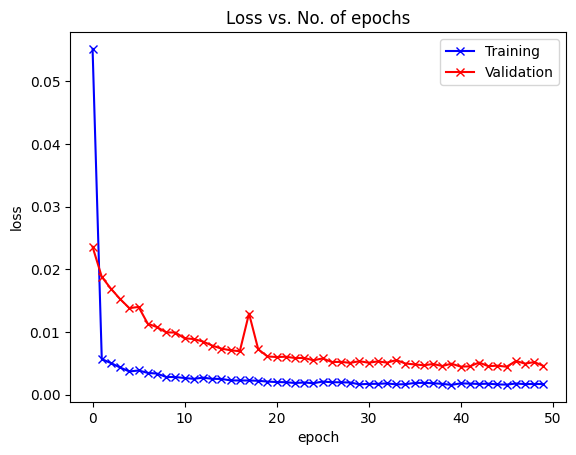

In [54]:
# model selection
model_name = 'rnn'
model = get_model(model_name, model_params)

# optimizer and loss
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
# scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
scheduler = ExponentialLR(optimizer, gamma=0.95)


rnn_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(rnn_results['train_loss'], rnn_results['val_loss'])

### Training with LSTM

Model will be saved to: ./model/^GSPC_lstm.pth
Using device: cpu with seed: 1311



Evaluating: 100%|██████████| 259/259 [00:01<00:00, 188.62it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 1/50, Train Loss: 0.2126, Val Loss: 0.2161, Time: 101.62s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 183.41it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 2/50, Train Loss: 0.0543, Val Loss: 0.1538, Time: 102.43s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 188.21it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 3/50, Train Loss: 0.0377, Val Loss: 0.0549, Time: 102.88s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 177.99it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 4/50, Train Loss: 0.0232, Val Loss: 0.0400, Time: 103.11s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 188.62it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 5/50, Train Loss: 0.0139, Val Loss: 0.0245, Time: 103.17s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 192.98it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 6/50, Train Loss: 0.0099, Val Loss: 0.0223, Time: 101.99s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 190.57it/s]


Epoch 7/50, Train Loss: 0.0082, Val Loss: 0.0254, Time: 102.80s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 190.57it/s]


Epoch 8/50, Train Loss: 0.0074, Val Loss: 0.0267, Time: 100.92s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 195.16it/s]


Epoch 9/50, Train Loss: 0.0068, Val Loss: 0.0248, Time: 101.47s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 207.02it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 10/50, Train Loss: 0.0072, Val Loss: 0.0223, Time: 95.99s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 203.92it/s]


Epoch 11/50, Train Loss: 0.0068, Val Loss: 0.0330, Time: 95.30s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 190.29it/s]


Epoch 12/50, Train Loss: 0.0061, Val Loss: 0.0224, Time: 95.29s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 200.60it/s]


Epoch 13/50, Train Loss: 0.0062, Val Loss: 0.0255, Time: 94.88s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 201.97it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 14/50, Train Loss: 0.0059, Val Loss: 0.0223, Time: 95.14s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 197.70it/s]


Epoch 15/50, Train Loss: 0.0061, Val Loss: 0.0235, Time: 95.88s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 206.03it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 16/50, Train Loss: 0.0057, Val Loss: 0.0207, Time: 95.11s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 188.21it/s]


Epoch 17/50, Train Loss: 0.0057, Val Loss: 0.0244, Time: 95.27s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 207.85it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 18/50, Train Loss: 0.0056, Val Loss: 0.0205, Time: 95.06s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 194.14it/s]


Epoch 19/50, Train Loss: 0.0052, Val Loss: 0.0214, Time: 96.03s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 205.87it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 20/50, Train Loss: 0.0055, Val Loss: 0.0204, Time: 95.71s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 204.40it/s]


Epoch 21/50, Train Loss: 0.0051, Val Loss: 0.0217, Time: 95.73s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 206.82it/s]


Epoch 22/50, Train Loss: 0.0049, Val Loss: 0.0241, Time: 95.01s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 198.45it/s]


Epoch 23/50, Train Loss: 0.0051, Val Loss: 0.0206, Time: 94.40s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 203.76it/s]


Epoch 24/50, Train Loss: 0.0049, Val Loss: 0.0212, Time: 94.83s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 206.52it/s]


Epoch 25/50, Train Loss: 0.0048, Val Loss: 0.0208, Time: 93.98s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 190.57it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 26/50, Train Loss: 0.0049, Val Loss: 0.0198, Time: 95.59s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 201.86it/s]


Epoch 27/50, Train Loss: 0.0048, Val Loss: 0.0199, Time: 94.84s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 204.40it/s]


Epoch 28/50, Train Loss: 0.0049, Val Loss: 0.0213, Time: 95.03s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 195.16it/s]


Epoch 29/50, Train Loss: 0.0045, Val Loss: 0.0204, Time: 94.44s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 201.38it/s]


Epoch 30/50, Train Loss: 0.0043, Val Loss: 0.0200, Time: 94.97s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 207.35it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 31/50, Train Loss: 0.0045, Val Loss: 0.0196, Time: 94.61s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 206.03it/s]


Epoch 32/50, Train Loss: 0.0045, Val Loss: 0.0198, Time: 96.37s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 194.72it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 33/50, Train Loss: 0.0045, Val Loss: 0.0196, Time: 94.30s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 190.27it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 34/50, Train Loss: 0.0046, Val Loss: 0.0195, Time: 98.62s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 204.89it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 35/50, Train Loss: 0.0046, Val Loss: 0.0195, Time: 99.34s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 196.94it/s]


Epoch 36/50, Train Loss: 0.0043, Val Loss: 0.0195, Time: 95.64s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 192.28it/s]


Epoch 37/50, Train Loss: 0.0044, Val Loss: 0.0200, Time: 96.50s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 205.21it/s]


Epoch 38/50, Train Loss: 0.0046, Val Loss: 0.0196, Time: 95.29s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 202.80it/s]


Epoch 39/50, Train Loss: 0.0043, Val Loss: 0.0197, Time: 95.31s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 199.68it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 40/50, Train Loss: 0.0043, Val Loss: 0.0194, Time: 94.27s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 203.76it/s]


Epoch 41/50, Train Loss: 0.0046, Val Loss: 0.0197, Time: 96.58s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 207.02it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 42/50, Train Loss: 0.0043, Val Loss: 0.0194, Time: 94.73s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 194.43it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 43/50, Train Loss: 0.0045, Val Loss: 0.0194, Time: 95.96s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 190.27it/s]


Epoch 44/50, Train Loss: 0.0043, Val Loss: 0.0196, Time: 95.52s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 202.96it/s]


Epoch 45/50, Train Loss: 0.0043, Val Loss: 0.0196, Time: 96.62s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 205.21it/s]


Epoch 46/50, Train Loss: 0.0042, Val Loss: 0.0195, Time: 95.99s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 206.03it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 47/50, Train Loss: 0.0046, Val Loss: 0.0193, Time: 96.19s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 205.54it/s]


Epoch 48/50, Train Loss: 0.0046, Val Loss: 0.0194, Time: 96.02s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 199.52it/s]


Model improved and saved to ./model/^GSPC_lstm.pth
Epoch 49/50, Train Loss: 0.0042, Val Loss: 0.0193, Time: 96.92s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 191.27it/s]


Epoch 50/50, Train Loss: 0.0041, Val Loss: 0.0194, Time: 97.22s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 130/130 [00:00<00:00, 191.16it/s]


Test Loss: 0.0143


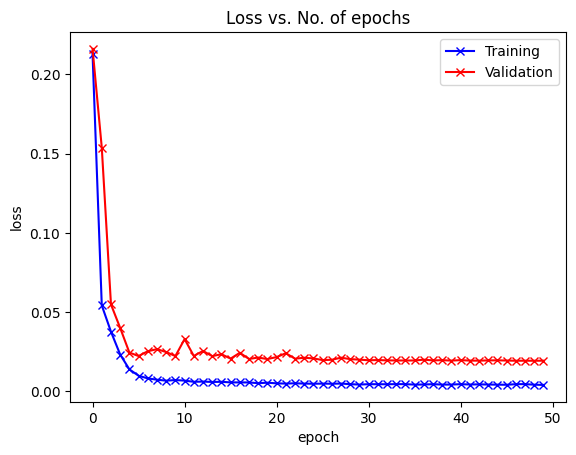

In [55]:
# model selection
model_name = 'lstm'
model = get_model(model_name, model_params)

# optimizer and loss
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
# scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
scheduler = ExponentialLR(optimizer, gamma=0.95)



lstm_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(lstm_results['train_loss'], lstm_results['val_loss'])

### Training with GRU

Model will be saved to: ./model/^GSPC_gru.pth
Using device: cpu with seed: 1311



Training:   0%|          | 0/907 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 259/259 [00:00<00:00, 273.47it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 1/50, Train Loss: 0.1287, Val Loss: 0.0971, Time: 70.05s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 267.27it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 2/50, Train Loss: 0.0227, Val Loss: 0.0276, Time: 69.49s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 265.62it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 3/50, Train Loss: 0.0083, Val Loss: 0.0240, Time: 70.39s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 269.21it/s]


Epoch 4/50, Train Loss: 0.0059, Val Loss: 0.0245, Time: 69.45s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 269.49it/s]


Epoch 5/50, Train Loss: 0.0052, Val Loss: 0.0276, Time: 69.06s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 268.93it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 6/50, Train Loss: 0.0049, Val Loss: 0.0207, Time: 69.96s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 269.49it/s]


Epoch 7/50, Train Loss: 0.0048, Val Loss: 0.0209, Time: 69.90s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 256.93it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 8/50, Train Loss: 0.0044, Val Loss: 0.0195, Time: 69.52s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 268.37it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 9/50, Train Loss: 0.0040, Val Loss: 0.0188, Time: 69.88s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 224.03it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 10/50, Train Loss: 0.0041, Val Loss: 0.0181, Time: 75.48s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 257.44it/s]


Epoch 11/50, Train Loss: 0.0040, Val Loss: 0.0206, Time: 74.28s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 255.66it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 12/50, Train Loss: 0.0034, Val Loss: 0.0173, Time: 73.01s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 230.41it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 13/50, Train Loss: 0.0036, Val Loss: 0.0171, Time: 74.69s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 248.78it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 14/50, Train Loss: 0.0034, Val Loss: 0.0167, Time: 73.89s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 246.41it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 15/50, Train Loss: 0.0035, Val Loss: 0.0163, Time: 73.27s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 255.66it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 16/50, Train Loss: 0.0034, Val Loss: 0.0162, Time: 75.25s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 261.93it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 17/50, Train Loss: 0.0031, Val Loss: 0.0161, Time: 73.29s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 264.00it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 18/50, Train Loss: 0.0032, Val Loss: 0.0156, Time: 74.64s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 258.20it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 19/50, Train Loss: 0.0030, Val Loss: 0.0152, Time: 73.93s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 248.07it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 20/50, Train Loss: 0.0030, Val Loss: 0.0150, Time: 73.56s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 260.28it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 21/50, Train Loss: 0.0027, Val Loss: 0.0149, Time: 73.91s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 262.39it/s]


Epoch 22/50, Train Loss: 0.0027, Val Loss: 0.0154, Time: 73.43s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 260.02it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 23/50, Train Loss: 0.0028, Val Loss: 0.0145, Time: 73.02s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 262.39it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 24/50, Train Loss: 0.0028, Val Loss: 0.0142, Time: 73.29s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 258.98it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 25/50, Train Loss: 0.0028, Val Loss: 0.0140, Time: 73.66s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 258.21it/s]


Epoch 26/50, Train Loss: 0.0028, Val Loss: 0.0142, Time: 74.78s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 268.10it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 27/50, Train Loss: 0.0026, Val Loss: 0.0136, Time: 71.95s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 265.08it/s]


Epoch 28/50, Train Loss: 0.0027, Val Loss: 0.0137, Time: 69.87s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 272.90it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 29/50, Train Loss: 0.0026, Val Loss: 0.0134, Time: 69.08s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 265.89it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 30/50, Train Loss: 0.0024, Val Loss: 0.0134, Time: 69.76s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 263.46it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 31/50, Train Loss: 0.0026, Val Loss: 0.0132, Time: 70.05s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 270.33it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 32/50, Train Loss: 0.0025, Val Loss: 0.0131, Time: 69.55s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 270.05it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 33/50, Train Loss: 0.0025, Val Loss: 0.0131, Time: 69.60s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 268.65it/s]


Epoch 34/50, Train Loss: 0.0025, Val Loss: 0.0135, Time: 71.12s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 261.86it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 35/50, Train Loss: 0.0025, Val Loss: 0.0129, Time: 69.36s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 260.02it/s]


Epoch 36/50, Train Loss: 0.0024, Val Loss: 0.0131, Time: 70.02s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 266.17it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 37/50, Train Loss: 0.0023, Val Loss: 0.0124, Time: 69.22s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 270.90it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 38/50, Train Loss: 0.0026, Val Loss: 0.0124, Time: 69.64s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 265.89it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 39/50, Train Loss: 0.0023, Val Loss: 0.0122, Time: 71.34s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 258.72it/s]


Epoch 40/50, Train Loss: 0.0024, Val Loss: 0.0124, Time: 69.69s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 242.04it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 41/50, Train Loss: 0.0026, Val Loss: 0.0121, Time: 69.45s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 270.33it/s]


Epoch 42/50, Train Loss: 0.0026, Val Loss: 0.0123, Time: 69.70s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 257.95it/s]


Epoch 43/50, Train Loss: 0.0026, Val Loss: 0.0123, Time: 69.08s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 261.33it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 44/50, Train Loss: 0.0023, Val Loss: 0.0119, Time: 69.94s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 264.00it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 45/50, Train Loss: 0.0025, Val Loss: 0.0119, Time: 69.80s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 257.69it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 46/50, Train Loss: 0.0024, Val Loss: 0.0118, Time: 69.86s


Evaluating: 100%|██████████| 259/259 [00:01<00:00, 253.90it/s]


Epoch 47/50, Train Loss: 0.0026, Val Loss: 0.0122, Time: 71.36s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 264.27it/s]


Epoch 48/50, Train Loss: 0.0024, Val Loss: 0.0120, Time: 69.72s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 270.05it/s]


Epoch 49/50, Train Loss: 0.0024, Val Loss: 0.0120, Time: 70.28s


Evaluating: 100%|██████████| 259/259 [00:00<00:00, 268.10it/s]


Model improved and saved to ./model/^GSPC_gru.pth
Epoch 50/50, Train Loss: 0.0023, Val Loss: 0.0117, Time: 70.05s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 130/130 [00:00<00:00, 200.29it/s]


Test Loss: 0.0103


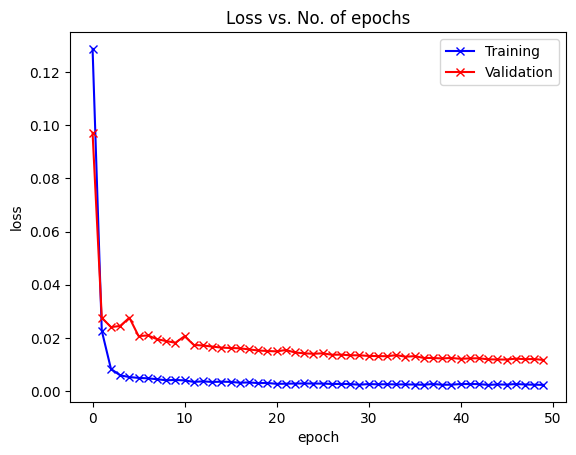

In [56]:
# model selection
model_name = 'gru'
model = get_model(model_name, model_params)

# optimizer and loss
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
# scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
scheduler = ExponentialLR(optimizer, gamma=0.95)



gru_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(gru_results['train_loss'], gru_results['val_loss'])

### Training with attention

Model will be saved to: ./model/^GSPC_birnn.pth
Using device: cpu with seed: 1311



Evaluating: 100%|██████████| 259/259 [00:02<00:00, 91.06it/s] 


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 1/50, Train Loss: 0.1367, Val Loss: 0.1691, Time: 251.81s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 93.73it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 2/50, Train Loss: 0.0404, Val Loss: 0.0330, Time: 253.07s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 93.06it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 3/50, Train Loss: 0.0158, Val Loss: 0.0226, Time: 254.10s


Evaluating: 100%|██████████| 259/259 [00:03<00:00, 83.60it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 4/50, Train Loss: 0.0070, Val Loss: 0.0224, Time: 254.32s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 93.73it/s]


Epoch 5/50, Train Loss: 0.0054, Val Loss: 0.0267, Time: 255.93s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 91.45it/s]


Epoch 6/50, Train Loss: 0.0051, Val Loss: 0.0227, Time: 252.12s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 92.30it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 7/50, Train Loss: 0.0047, Val Loss: 0.0211, Time: 252.76s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 90.71it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 8/50, Train Loss: 0.0044, Val Loss: 0.0202, Time: 254.04s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 95.95it/s]


Epoch 9/50, Train Loss: 0.0040, Val Loss: 0.0204, Time: 253.95s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 89.58it/s]


Epoch 10/50, Train Loss: 0.0039, Val Loss: 0.0205, Time: 255.43s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 88.98it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 11/50, Train Loss: 0.0036, Val Loss: 0.0195, Time: 263.15s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 92.86it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 12/50, Train Loss: 0.0036, Val Loss: 0.0191, Time: 265.99s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 91.06it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 13/50, Train Loss: 0.0034, Val Loss: 0.0189, Time: 264.54s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 91.64it/s]


Epoch 14/50, Train Loss: 0.0032, Val Loss: 0.0195, Time: 263.13s


Evaluating: 100%|██████████| 259/259 [00:03<00:00, 85.84it/s]


Epoch 15/50, Train Loss: 0.0032, Val Loss: 0.0193, Time: 262.56s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 90.24it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 16/50, Train Loss: 0.0031, Val Loss: 0.0184, Time: 262.26s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 91.38it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 17/50, Train Loss: 0.0030, Val Loss: 0.0182, Time: 266.19s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 91.25it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 18/50, Train Loss: 0.0030, Val Loss: 0.0181, Time: 263.80s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 88.33it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 19/50, Train Loss: 0.0030, Val Loss: 0.0178, Time: 263.96s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 90.22it/s]


Epoch 20/50, Train Loss: 0.0029, Val Loss: 0.0187, Time: 264.12s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 90.29it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 21/50, Train Loss: 0.0029, Val Loss: 0.0175, Time: 262.61s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 90.06it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 22/50, Train Loss: 0.0028, Val Loss: 0.0174, Time: 258.35s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 92.36it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 23/50, Train Loss: 0.0027, Val Loss: 0.0172, Time: 253.90s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 90.84it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 24/50, Train Loss: 0.0027, Val Loss: 0.0171, Time: 257.06s


Evaluating: 100%|██████████| 259/259 [00:03<00:00, 80.68it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 25/50, Train Loss: 0.0028, Val Loss: 0.0171, Time: 265.73s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 88.46it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 26/50, Train Loss: 0.0027, Val Loss: 0.0169, Time: 268.52s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 91.75it/s]


Epoch 27/50, Train Loss: 0.0028, Val Loss: 0.0170, Time: 264.78s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 93.13it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 28/50, Train Loss: 0.0028, Val Loss: 0.0168, Time: 259.14s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 92.36it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 29/50, Train Loss: 0.0026, Val Loss: 0.0166, Time: 252.88s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 92.13it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 30/50, Train Loss: 0.0025, Val Loss: 0.0165, Time: 253.30s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 93.26it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 31/50, Train Loss: 0.0025, Val Loss: 0.0164, Time: 254.27s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 94.04it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 32/50, Train Loss: 0.0025, Val Loss: 0.0162, Time: 253.43s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 91.48it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 33/50, Train Loss: 0.0024, Val Loss: 0.0162, Time: 252.56s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 90.65it/s]


Epoch 34/50, Train Loss: 0.0024, Val Loss: 0.0166, Time: 254.34s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 92.53it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 35/50, Train Loss: 0.0024, Val Loss: 0.0161, Time: 251.73s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 89.65it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 36/50, Train Loss: 0.0025, Val Loss: 0.0160, Time: 256.67s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 90.24it/s]


Epoch 37/50, Train Loss: 0.0026, Val Loss: 0.0161, Time: 264.15s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 89.64it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 38/50, Train Loss: 0.0024, Val Loss: 0.0159, Time: 265.15s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 91.03it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 39/50, Train Loss: 0.0024, Val Loss: 0.0158, Time: 265.14s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 91.51it/s]


Epoch 40/50, Train Loss: 0.0024, Val Loss: 0.0159, Time: 254.93s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 94.48it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 41/50, Train Loss: 0.0022, Val Loss: 0.0156, Time: 253.48s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 94.62it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 42/50, Train Loss: 0.0024, Val Loss: 0.0156, Time: 255.47s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 89.61it/s]


Epoch 43/50, Train Loss: 0.0025, Val Loss: 0.0156, Time: 258.50s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 89.54it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 44/50, Train Loss: 0.0024, Val Loss: 0.0155, Time: 265.16s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 89.63it/s]


Epoch 45/50, Train Loss: 0.0024, Val Loss: 0.0156, Time: 266.67s


Evaluating: 100%|██████████| 259/259 [00:03<00:00, 84.06it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 46/50, Train Loss: 0.0025, Val Loss: 0.0155, Time: 272.53s


Evaluating: 100%|██████████| 259/259 [00:03<00:00, 82.27it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 47/50, Train Loss: 0.0024, Val Loss: 0.0154, Time: 271.22s


Evaluating: 100%|██████████| 259/259 [00:03<00:00, 85.81it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 48/50, Train Loss: 0.0022, Val Loss: 0.0154, Time: 271.69s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 91.42it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 49/50, Train Loss: 0.0023, Val Loss: 0.0153, Time: 267.42s


Evaluating: 100%|██████████| 259/259 [00:02<00:00, 90.24it/s]


Model improved and saved to ./model/^GSPC_birnn.pth
Epoch 50/50, Train Loss: 0.0022, Val Loss: 0.0153, Time: 260.33s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 130/130 [00:01<00:00, 88.43it/s]


Test Loss: 0.0133


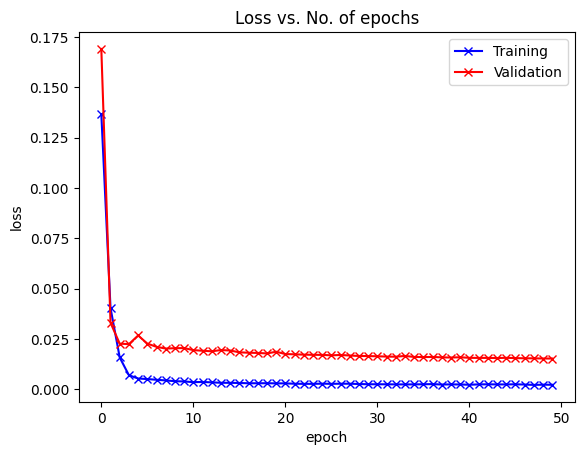

In [57]:
# model selection
model_name = 'birnn'
model = get_model(model_name, model_params)

# optimizer and loss
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, ExponentialLR
# scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
scheduler = ExponentialLR(optimizer, gamma=0.95)



birnn_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(birnn_results['train_loss'], birnn_results['val_loss'])

## Step 06: Evaluation with Testing Set

### Testing on each experiment

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

In [66]:
df_result = {}
df_result['rnn'] = format_predictions(rnn_results['test_pred'], rnn_results['test_actual'], X_test, scaler)
df_result['lstm'] = format_predictions(lstm_results['test_pred'], lstm_results['test_actual'], X_test, scaler)
df_result['gru'] = format_predictions(gru_results['test_pred'], gru_results['test_actual'], X_test, scaler)
df_result['birnn'] = format_predictions(birnn_results['test_pred'], birnn_results['test_actual'], X_test, scaler)
df_result

{'rnn':                value  prediction
 date                            
 2020-05-08  1.994079    1.977579
 2020-05-11  1.994344    1.958033
 2020-05-12  1.953459    1.925689
 2020-05-13  1.919347    1.911634
 2020-05-14  1.941467    1.937639
 ...              ...         ...
 2020-11-04  2.343672    2.309723
 2020-11-05  2.389280    2.326656
 2020-11-06  2.388593    2.294361
 2020-11-09  2.416539    2.309872
 2020-11-10  2.413157    2.297198
 
 [130 rows x 2 columns],
 'lstm':                value  prediction
 date                            
 2020-05-08  1.994079    2.030959
 2020-05-11  1.994344    2.012015
 2020-05-12  1.953459    2.012031
 2020-05-13  1.919347    2.001874
 2020-05-14  1.941467    1.997514
 ...              ...         ...
 2020-11-04  2.343672    2.258871
 2020-11-05  2.389280    2.269288
 2020-11-06  2.388593    2.255074
 2020-11-09  2.416539    2.252105
 2020-11-10  2.413157    2.251116
 
 [130 rows x 2 columns],
 'gru':                value  prediction
 date 

In [67]:
# for i in df_result.keys():
    # print(i)

In [68]:
result_metrics = {}
result_metrics['rnn']  = calculate_metrics(df_result['rnn'])
result_metrics['lstm']  = calculate_metrics(df_result['lstm'])
result_metrics['gru']  = calculate_metrics(df_result['gru'])
result_metrics['birnn']  = calculate_metrics(df_result['birnn'])
result_metrics

{'rnn': {'mae': 0.04087803,
  'rmse': 0.04883633782935625,
  'r2': 0.8374463108224863},
 'lstm': {'mae': 0.077390105,
  'rmse': 0.09068067131452033,
  'r2': 0.4395458735127209},
 'gru': {'mae': 0.065525785,
  'rmse': 0.07700548931896628,
  'r2': 0.5958393738559851},
 'birnn': {'mae': 0.07456231,
  'rmse': 0.08759737631371378,
  'r2': 0.4770106982452347}}

### compare to baseline

In [69]:
from sklearn.linear_model import LinearRegression

def build_baseline_model(df, test_ratio, target_col):
    # X, y = feature_label_split(df, target_col)
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, 'value')
    X_t_train = X_train.append(X_val)
    y_t_train = y_train.append(y_val)
    model = LinearRegression()
    model.fit(X_t_train, y_t_train)
    prediction = model.predict(X_test)

    result = pd.DataFrame(y_test)
    result["prediction"] = prediction
    result = result.sort_index()

    return result

df_baseline = build_baseline_model(df_feature, 0.2, 'value')
baseline_metrics = calculate_metrics(df_baseline)
baseline_metrics

Training size: 907 period 2015-09-21 00:00:00 to 2019-04-29 00:00:00 
Validation size: 259 period 2019-04-30 00:00:00 to 2020-05-07 00:00:00
test_data size: 130 period 2020-05-08 00:00:00 to 2020-11-10 00:00:00


{'mae': 5.277829455525744e-16, 'rmse': 6.024548683609278e-16, 'r2': 1.0}

In [70]:
df_baseline

,value,prediction
date,,
2020-05-08,1.994079,1.994079
2020-05-11,1.994344,1.994344
2020-05-12,1.953459,1.953459
2020-05-13,1.919347,1.919347
2020-05-14,1.941467,1.941467
...,...,...
2020-11-04,2.343672,2.343672
2020-11-05,2.389280,2.389280
2020-11-06,2.388593,2.388593


### visualize the results

In [71]:
def plot_predictions(df_result, df_baseline):
    data = []
    
    # value = go.Scatter(
    #     x=df_result.index,
    #     y=df_result.value,
    #     mode="lines",
    #     name="values",
    #     marker=dict(),
    #     text=df_result.index,
    #     line=dict(color="rgba(0,0,0, 0.3)"),
    # )
    # data.append(value)

    baseline = go.Scatter(
        x=df_baseline.index,
        y=df_baseline.prediction,
        mode="lines",
        line={"dash": "solid","color":"red"},
        name='linear regression',
        marker=dict(),
        text=df_baseline.index,
        opacity=0.8,
    )
    data.append(baseline)
    
    # prediction = go.Scatter(
    #     x=df_result.index,
    #     y=df_result.prediction,
    #     mode="lines",
    #     line={"dash": "dot"},
    #     name='predictions',
    #     marker=dict(),
    #     text=df_result.index,
    #     opacity=0.8,
    # )
    # data.append(prediction)
    
    n = 0
    for dict_key, dict_val in df_result.items():
        
        if n == 0:
            value = go.Scatter(
            x=dict_val.index,
            y=dict_val.value,
            mode="lines",
            name="values",
            marker=dict(),
            text=dict_val.index,
            line=dict(color="rgba(0,0,0, 0.3)"),
            )
            data.append(value)
            n += 1
        
        prediction = go.Scatter(
            x=dict_val.index,
            y=dict_val.prediction,
            mode="lines",
            line={"dash": "dot"},
            name=f'model {dict_key}',
            marker=dict(),
            text=dict_val.index,
            opacity=0.8,
        )
        data.append(prediction)
    
    layout = dict(
        title="Predictions vs Actual Values for the dataset",
        xaxis=dict(title="Time", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=True, range=[0, 'auto'])
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [72]:
plot_predictions(df_result, df_baseline)